In [1]:

!pip install -q gdown

In [2]:
!gdown --id 1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=3bd34ee2-cbe3-4882-ade1-5931c8b24bd0
To: /content/dataset.zip
100% 1.13G/1.13G [00:05<00:00, 206MB/s]


In [3]:
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = 3
LEARNING_RATE = 0.001
IMG_SIZE = 224  # ResNet expects 224x224 images

# Dataset path
data_dir = 'extracted_data/dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Class names
class_names = ['no', 'sphere', 'vort']

In [6]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Map class names to numeric labels
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

        # Collect all samples
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: Directory {class_dir} not found")
                continue

            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    self.samples.append((
                        os.path.join(class_dir, file_name),
                        self.class_to_idx[class_name]
                    ))

        print(f"Found {len(self.samples)} samples in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            # Load .npy file
            image = np.load(img_path)

            # Convert to tensor
            image = torch.from_numpy(image).float()

            # Ensure image has the correct dimensions
            if len(image.shape) == 2:  # Single channel
                # Add channel dimension
                image = image.unsqueeze(0)
                # Repeat to get 3 channels if using a pretrained model
                image = image.repeat(3, 1, 1)
            elif len(image.shape) == 3 and image.shape[0] != 3:
                # If image has 3 dimensions but first dimension is not 3
                # Assume it's (H, W, C) format and convert to (C, H, W)
                image = image.permute(2, 0, 1)

            # Resize if needed
            if image.shape[1] != IMG_SIZE or image.shape[2] != IMG_SIZE:
                image = F.interpolate(image.unsqueeze(0), size=(IMG_SIZE, IMG_SIZE),
                                     mode='bilinear', align_corners=False).squeeze(0)

            # Apply additional transforms if available
            if self.transform:
                # Convert to PIL for transforms
                image_np = image.numpy().transpose(1, 2, 0)
                image_np = np.clip(image_np, 0, 1)

                if image_np.shape[2] == 1:
                    image_pil = Image.fromarray((image_np[:,:,0] * 255).astype(np.uint8), mode='L')
                else:
                    image_pil = Image.fromarray((image_np * 255).astype(np.uint8), mode='RGB')

                image = self.transform(image_pil)

            return image, label

        except Exception as e:
            print(f"Error loading file {img_path}: {e}")
            # Return a placeholder in case of error
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), label


In [7]:
def print_dataset_structure(base_dir):
    print(f"Exploring directory: {base_dir}")
    if not os.path.exists(base_dir):
        print(f"Directory {base_dir} does not exist!")
        return

    for root, dirs, files in os.walk(base_dir):
        level = root.replace(base_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")

        file_indent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Show only first 5 files
            print(f"{file_indent}{f}")
        if len(files) > 5:
            print(f"{file_indent}... and {len(files)-5} more files")

print("Dataset directory structure:")
print_dataset_structure(data_dir)

Dataset directory structure:
Exploring directory: extracted_data/dataset
dataset/
    .DS_Store
    train/
        .DS_Store
        vort/
            955.npy
            3087.npy
            2899.npy
            9392.npy
            2221.npy
            ... and 9995 more files
        no/
            955.npy
            3087.npy
            2899.npy
            9392.npy
            2221.npy
            ... and 9995 more files
        sphere/
            955.npy
            3087.npy
            2899.npy
            9392.npy
            2221.npy
            ... and 9995 more files
    val/
        .DS_Store
        vort/
            955.npy
            2221.npy
            196.npy
            2113.npy
            1877.npy
            ... and 2495 more files
        no/
            955.npy
            2221.npy
            196.npy
            2113.npy
            1877.npy
            ... and 2495 more files
        sphere/
            955.npy
            2221.npy
            196.npy
     

In [8]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Found 30000 samples in extracted_data/dataset/train
Found 7500 samples in extracted_data/dataset/val
Training samples: 30000
Validation samples: 7500
Sample images from training set:


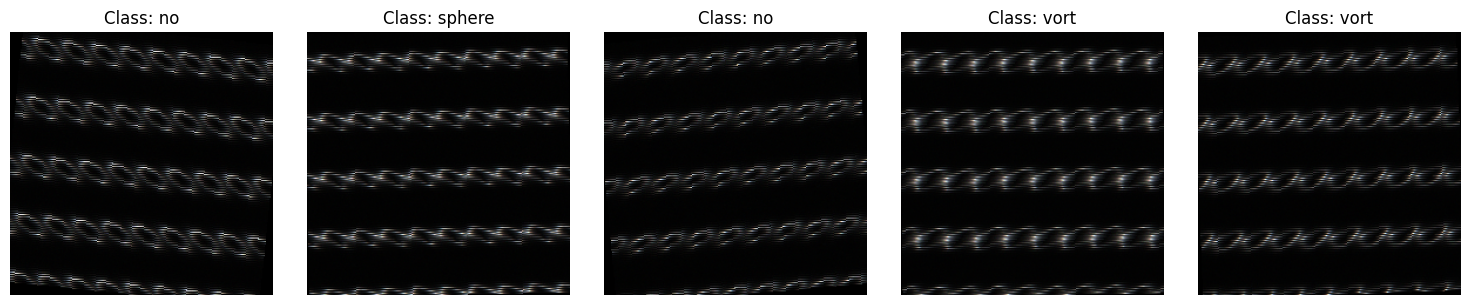

In [9]:
train_dataset = LensingDataset(train_dir, transform=data_transforms['train'])
val_dataset = LensingDataset(val_dir, transform=data_transforms['val'])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Make sure we have data before proceeding
if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("Datasets are empty! Please check the file paths and formats.")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Sample visualization function
def visualize_samples(dataset, num_samples=5):
    if len(dataset) == 0:
        print("Cannot visualize - dataset is empty!")
        return

    # Adjust number of samples if dataset is smaller
    num_samples = min(num_samples, len(dataset))

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # Handle case where there's only one sample
    if num_samples == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # Convert tensor to numpy for visualization
        img = img.numpy().transpose((1, 2, 0))

        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Try to visualize samples if possible
try:
    print("Sample images from training set:")
    visualize_samples(train_dataset)
except Exception as e:
    print(f"Error visualizing samples: {e}")


In [10]:
def create_model():
    # Load pre-trained ResNet-50
    model = models.resnet50(weights='DEFAULT')

    # Freeze some early layers to prevent overfitting
    for name, param in list(model.named_parameters())[:50]:  # Freeze first 50 layers
        param.requires_grad = False

    # Modify the final layer for our 3-class classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, NUM_CLASSES)
    )

    return model

# Initialize model
model = create_model().to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def train_model():
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = correct / total

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Record history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{NUM_EPOCHS} | '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return history

In [12]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def compute_roc_auc():
    # Set model to evaluation mode
    model.eval()

    # Collect all predictions and true labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate batches
    all_preds = np.vstack(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(NUM_CLASSES):
        # Convert to one-vs-rest binary classification
        binary_labels = np.zeros(all_labels.shape)
        binary_labels[all_labels == i] = 1

        fpr[i], tpr[i], _ = roc_curve(binary_labels, all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve and ROC area
    # First aggregate all true positives and false positives
    binary_labels = np.zeros((len(all_labels), NUM_CLASSES))
    for i in range(NUM_CLASSES):
        binary_labels[:, i] = (all_labels == i).astype(int)

    fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), all_preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calculate macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= NUM_CLASSES
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

    for i, color in zip(range(NUM_CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Return the AUC scores
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    for i in range(NUM_CLASSES):
        print(f"AUC for class {class_names[i]}: {roc_auc[i]:.4f}")

    return roc_auc

In [14]:
def plot_confusion_matrix():
    # Set model to evaluation mode
    model.eval()

    # Collect all predictions and true labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate batches
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
    for i in range(len(all_labels)):
        conf_matrix[all_labels[i], all_preds[i]] += 1

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Calculate per-class metrics
    precision = np.zeros(NUM_CLASSES)
    recall = np.zeros(NUM_CLASSES)
    f1_score = np.zeros(NUM_CLASSES)

    for i in range(NUM_CLASSES):
        # Precision = TP / (TP + FP)
        precision[i] = conf_matrix[i, i] / np.sum(conf_matrix[:, i]) if np.sum(conf_matrix[:, i]) > 0 else 0

        # Recall = TP / (TP + FN)
        recall[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) > 0 else 0

        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    for i in range(NUM_CLASSES):
        print(f"Class {class_names[i]}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1_score[i]:.4f}")

In [ ]:
if len(train_dataset) > 0 and len(val_dataset) > 0:
    print("Starting training...")
    history = train_model()
    plot_history(history)

    print("\nComputing ROC curves and AUC scores...")
    compute_roc_auc()

    print("\nPlotting confusion matrix...")
    plot_confusion_matrix()

    # Save the model
    torch.save(model.state_dict(), 'lensing_classifier.pth')
    print("Model saved to 'lensing_classifier.pth'")
else:
    print("Cannot train model - datasets are empty!")

Starting training...
